In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

# Load the CSVs for the three ultrasound modalities
df_B_mode_train = pd.read_csv('../Custom_CNN_B_Mode_Stratified/train_features_custom_CNN.csv')
df_B_mode_test = pd.read_csv('../Custom_CNN_B_Mode_Stratified/test_features_custom_CNN.csv')

df_IE_train = pd.read_csv('../Custom_CNN_IE_Stratified/train_features_custom_CNN.csv')
df_IE_test = pd.read_csv('../Custom_CNN_IE_Stratified/test_features_custom_CNN.csv')

df_IQ_train = pd.read_csv('../Custom_CNN_IQ_Stratified/train_features_custom_CNN.csv')
df_IQ_test = pd.read_csv('../Custom_CNN_IQ_Stratified/test_features_custom_CNN.csv')

# ✅ Remove 'Label' columns from df_IE and df_IQ before merging
label_column = 'Label'  
df_IE_train = df_IE_train.drop(columns=[label_column])
df_IE_test = df_IE_test.drop(columns=[label_column])
df_IQ_train = df_IQ_train.drop(columns=[label_column])
df_IQ_test = df_IQ_test.drop(columns=[label_column])

# ✅ Convert labels to torch tensors
y_train = torch.tensor(df_B_mode_train['Label'].to_numpy(), dtype=torch.long)
y_test = torch.tensor(df_B_mode_test['Label'].to_numpy(), dtype=torch.long)

# ✅ Convert feature matrices to float32
X_train_B = torch.tensor(df_B_mode_train.drop(columns=['Image', 'Label']).to_numpy(), dtype=torch.float32)
X_train_IE = torch.tensor(df_IE_train.drop(columns=['Image']).to_numpy(), dtype=torch.float32)
X_train_IQ = torch.tensor(df_IQ_train.drop(columns=['Image']).to_numpy(), dtype=torch.float32)

X_test_B = torch.tensor(df_B_mode_test.drop(columns=['Image', 'Label']).to_numpy(), dtype=torch.float32)
X_test_IE = torch.tensor(df_IE_test.drop(columns=['Image']).to_numpy(), dtype=torch.float32)
X_test_IQ = torch.tensor(df_IQ_test.drop(columns=['Image']).to_numpy(), dtype=torch.float32)

# ✅ Stack features into a tensor: (batch_size, 3, 512)
X_train = torch.stack([X_train_B, X_train_IE, X_train_IQ], dim=1)
X_test = torch.stack([X_test_B, X_test_IE, X_test_IQ], dim=1)

# ✅ Track Image Names
image_names_train = df_B_mode_train['Image'].to_numpy()
image_names_test = df_B_mode_test['Image'].to_numpy()

# ✅ Custom Dataset Class
class MultiModalDataset(Dataset):
    def __init__(self, features, labels, image_names):
        self.features = features
        self.labels = labels
        self.image_names = image_names

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx], self.image_names[idx]

# ✅ Create Datasets and Dataloaders
batch_size = 128
train_dataset = MultiModalDataset(X_train, y_train, image_names_train)
test_dataset = MultiModalDataset(X_test, y_test, image_names_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [2]:
print(X_train.shape, y_train.shape)

torch.Size([9789, 3, 512]) torch.Size([9789])


In [3]:
import torch.nn as nn
import torch.nn.functional as F

class TransformerFusion(nn.Module):
    def __init__(self, feature_dim=512, num_classes=6, num_heads=4, num_layers=2, dropout=0.3):
        super(TransformerFusion, self).__init__()

        self.proj = nn.Linear(feature_dim, feature_dim)  # Project each modality to a common space

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=feature_dim, nhead=num_heads, dropout=dropout, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Feature Extraction Layer (before classification)
        self.feature_extractor = nn.Linear(feature_dim, 256)  # Extract 256-D feature representation

        # Classification Head
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        """
        x: Tensor of shape (batch_size, 3, 512)
        """
        x = self.proj(x)  # Project features to common space
        x = self.transformer(x)  # Self-attention over modality features
        x = x.mean(dim=1)  # Aggregate across modalities
        features = self.feature_extractor(x)  # Extract features
        logits = self.fc(features)  # Final classification

        return logits

    def extract_features(self, x):
        """
        Extracts 256-D feature vector before classification.
        """
        x = self.proj(x)
        x = self.transformer(x)
        x = x.mean(dim=1)
        return self.feature_extractor(x)  # Extracted features

# ✅ Initialize Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TransformerFusion(feature_dim=512, num_classes=6).to(device)

Training:   2%|▏         | 1/50 [00:18<15:10, 18.58s/it]

Epoch 1: Train Loss=0.9768, Train Acc=75.25%, Val Loss=0.7141, Val Acc=88.63%
✅ Best model saved (Epoch 1, Val Acc=88.63%)


Training:   4%|▍         | 2/50 [00:45<18:43, 23.41s/it]

Epoch 2: Train Loss=0.5450, Train Acc=95.61%, Val Loss=0.6955, Val Acc=89.70%
✅ Best model saved (Epoch 2, Val Acc=89.70%)


Training:   6%|▌         | 3/50 [01:08<18:24, 23.50s/it]

Epoch 3: Train Loss=0.5344, Train Acc=95.85%, Val Loss=0.7001, Val Acc=88.32%


Training:   8%|▊         | 4/50 [01:28<16:49, 21.95s/it]

Epoch 4: Train Loss=0.5215, Train Acc=96.35%, Val Loss=0.7094, Val Acc=87.90%


Training:  10%|█         | 5/50 [02:08<21:15, 28.35s/it]

Epoch 5: Train Loss=0.5252, Train Acc=96.38%, Val Loss=0.6929, Val Acc=88.40%


Training:  12%|█▏        | 6/50 [02:38<21:22, 29.14s/it]

Epoch 6: Train Loss=0.5226, Train Acc=96.48%, Val Loss=0.7493, Val Acc=87.67%


Training:  12%|█▏        | 6/50 [03:00<22:07, 30.16s/it]

Epoch 7: Train Loss=0.5161, Train Acc=96.76%, Val Loss=0.6775, Val Acc=89.43%
⏹ Stopping early at epoch 7. Best Val Acc: 89.70%


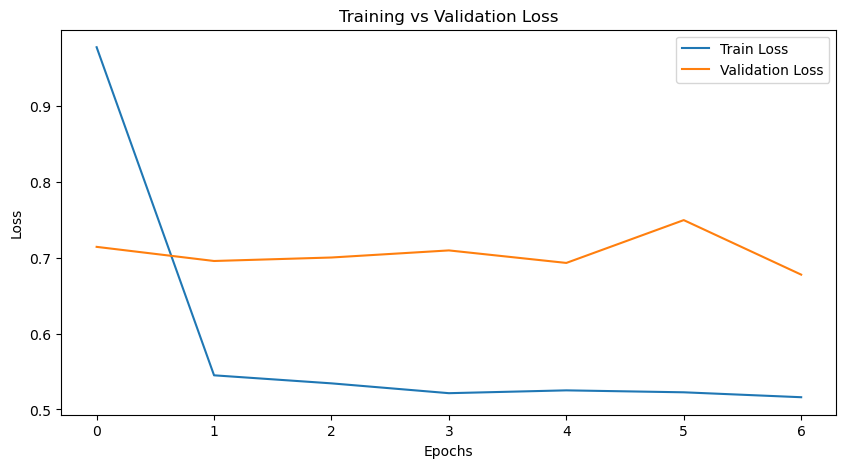

✅ Model training complete and saved successfully!


In [4]:
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import accuracy_score

# ✅ Define Loss Function & Optimizer
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=5e-4, weight_decay=5e-3)

# ✅ Early Stopping Parameters
best_val_acc = 0.0
patience = 5  # Stop if validation accuracy doesn't improve for 5 epochs
counter = 0

# ✅ Lists to store loss/accuracy
train_losses, val_losses, val_accuracies = [], [], []

# ✅ Training Loop
num_epochs = 50
for epoch in tqdm(range(num_epochs), desc="Training", total=num_epochs):
    model.train()
    epoch_loss, correct, total = 0, 0, 0

    for features, labels, _ in train_loader:
        features, labels = features.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total
    train_losses.append(epoch_loss / len(train_loader))

    # ✅ Validation Step
    model.eval()
    val_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for features, labels, _ in test_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)

    val_acc = 100 * correct / total
    val_losses.append(val_loss / len(test_loader))
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}: Train Loss={train_losses[-1]:.4f}, Train Acc={train_acc:.2f}%, Val Loss={val_losses[-1]:.4f}, Val Acc={val_acc:.2f}%")

    # ✅ Early Stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        counter = 0
        torch.save(model.state_dict(), "best_transformer.pth")
        print(f"✅ Best model saved (Epoch {epoch+1}, Val Acc={best_val_acc:.2f}%)")
    else:
        counter += 1
        if counter >= patience:
            print(f"⏹ Stopping early at epoch {epoch+1}. Best Val Acc: {best_val_acc:.2f}%")
            break

# ✅ Plot Loss Curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

print("✅ Model training complete and saved successfully!")

In [5]:
import torch
import numpy as np
import pandas as pd

# ✅ Load the best model and set to evaluation mode
model.load_state_dict(torch.load("best_transformer.pth"))  
model.eval()

# ✅ Initialize storage lists
X_train_features, y_train_labels, img_train_names = [], [], []
X_test_features, y_test_labels, img_test_names = [], [], []

pseudo_probs_train, pseudo_probs_test = [], []  # Store full class probabilities

# ✅ Extract Training Features
with torch.no_grad():
    for features, labels, img_names in train_loader:
        features, labels = features.to(device), labels.to(device)

        extracted_features = model.extract_features(features)  # Extract 256-D features
        X_train_features.append(extracted_features.cpu().numpy())
        y_train_labels.append(labels.cpu().numpy())
        img_train_names.extend(img_names)  

        # ✅ Compute pseudo-probabilities
        outputs = torch.softmax(model(features), dim=1)
        pseudo_probs_train.append(outputs.cpu().numpy())

# ✅ Extract Test Features
    for features, labels, img_names in test_loader:
        features, labels = features.to(device), labels.to(device)

        extracted_features = model.extract_features(features)
        X_test_features.append(extracted_features.cpu().numpy())
        y_test_labels.append(labels.cpu().numpy())
        img_test_names.extend(img_names)  

        outputs = torch.softmax(model(features), dim=1)
        pseudo_probs_test.append(outputs.cpu().numpy())

# ✅ Convert to NumPy arrays
X_train_features = np.concatenate(X_train_features)
y_train_labels = np.concatenate(y_train_labels)
X_test_features = np.concatenate(X_test_features)
y_test_labels = np.concatenate(y_test_labels)

pseudo_probs_train = np.concatenate(pseudo_probs_train)  # Shape: (num_samples, num_classes)
pseudo_probs_test = np.concatenate(pseudo_probs_test)    # Shape: (num_samples, num_classes)

# ✅ Save Features & Probabilities in CSV
df_train_features = pd.DataFrame(X_train_features)
df_train_features['Label'] = y_train_labels
df_train_features['Image'] = img_train_names

for i in range(pseudo_probs_train.shape[1]):
    df_train_features[f'Pseudo_Prob_Class_{i}'] = pseudo_probs_train[:, i]

df_train_features.to_csv('train_features_transformer.csv', index=False)

df_test_features = pd.DataFrame(X_test_features)
df_test_features['Label'] = y_test_labels
df_test_features['Image'] = img_test_names

for i in range(pseudo_probs_test.shape[1]):
    df_test_features[f'Pseudo_Prob_Class_{i}'] = pseudo_probs_test[:, i]

df_test_features.to_csv('test_features_transformer.csv', index=False)

print("✅ Transformer features and pseudo-label confidences extracted and saved successfully!")

/var/folders/gk/dsypcq4n5hg6hh5qdss0ly540000gn/T/ipykernel_20807/358846903.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_transfo

✅ Transformer features and pseudo-label confidences extracted and saved successfully!
